In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc, r2_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import hstack
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV

import time
import joblib
import os
import re
import string
%matplotlib inline

## Thu thập dữ liệu và xử lý dữ liệu

In [100]:
df = pd.read_csv('/content/real_drug_dataset.csv' )
# Lấy dữ liệu mẫu
print('Số cột và dòng:', df.shape)
print('\nKiểu dữ liệu:')
print(df.dtypes)

# Thông tin dữ liệu
print('\nThông tin dữ liệu:')
print(df.info())

# Kiểm tra các dữ liệu thiếu
print('\nCác dữ liệu thiếu:')
print(df.isnull().sum())

# Tổng quan về số liệu thống kê tóm tắt cho các cột số.
print('\nThống kê tóm tắt:')
print(df.describe())

# Phân phối các hàm
print('\nPhân phối các hàm:')
print(df.value_counts())

Số cột và dòng: (1000, 9)

Kiểu dữ liệu:
Patient_ID                  object
Age                          int64
Gender                      object
Condition                   object
Drug_Name                   object
Dosage_mg                    int64
Treatment_Duration_days      int64
Side_Effects                object
Improvement_Score          float64
dtype: object

Thông tin dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Patient_ID               1000 non-null   object 
 1   Age                      1000 non-null   int64  
 2   Gender                   1000 non-null   object 
 3   Condition                1000 non-null   object 
 4   Drug_Name                1000 non-null   object 
 5   Dosage_mg                1000 non-null   int64  
 6   Treatment_Duration_days  1000 non-null   int64  
 7   Side_Effects  

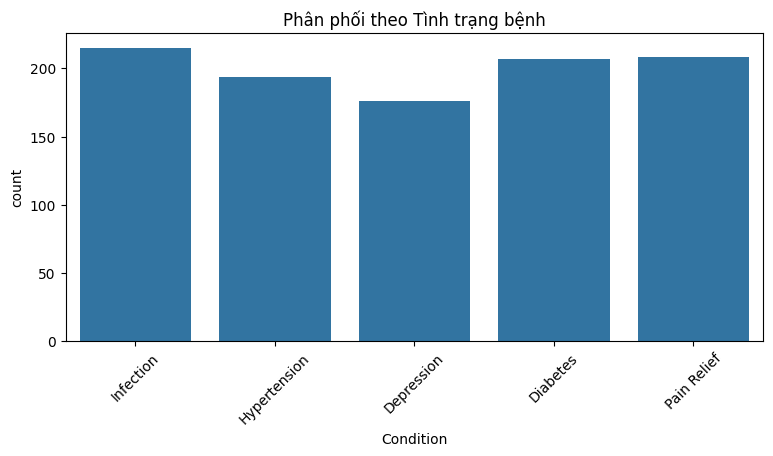

In [101]:
plt.figure(figsize=(9, 4))
sns.countplot(x='Condition', data=df)
plt.title('Phân phối theo Tình trạng bệnh')
plt.xticks(rotation=45)
plt.show()

##Làm sạch và tiền xử lý dữ liệu

In [102]:
#Tạo bản sao
df2 = df.copy()

# Kiểm tra các dòng trùng lặp
print('Số dòng trùng lặp:', df2.duplicated().sum())

# Loại bỏ các dòng trùng lặp (nếu có)
df2.drop_duplicates(inplace=True)

# Chuyển đổi các cột phân loại thành kiểu dữ liệu 'category'
categorical_cols = ['Patient_ID', 'Gender', 'Condition', 'Drug_Name', 'Side_Effects']
for col in categorical_cols:
    df2[col] = df2[col].astype('category')

# Hiển thị thông tin sau khi làm sạch dữ liệu
print('\nKiểu dữ liệu sau khi làm sạch:')
print(df2.dtypes)

Số dòng trùng lặp: 0

Kiểu dữ liệu sau khi làm sạch:
Patient_ID                 category
Age                           int64
Gender                     category
Condition                  category
Drug_Name                  category
Dosage_mg                     int64
Treatment_Duration_days       int64
Side_Effects               category
Improvement_Score           float64
dtype: object


## Phân tích dữ liệu (EDA)

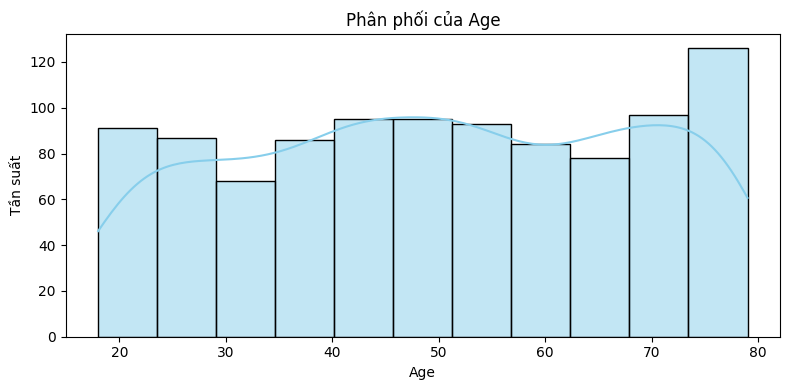

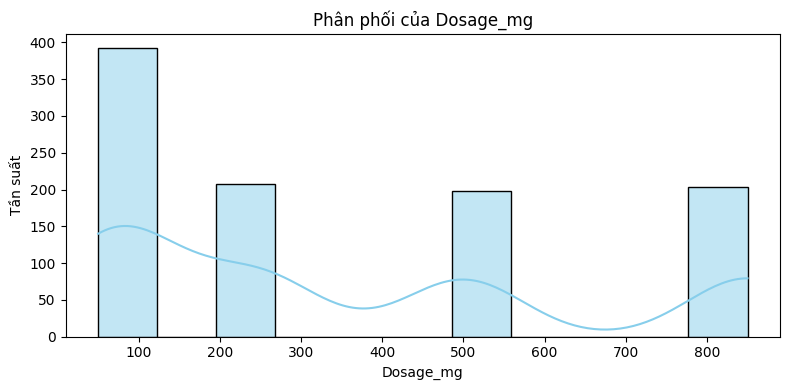

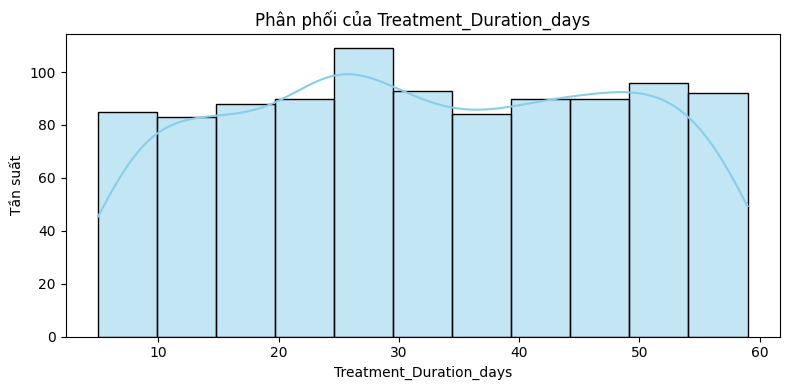

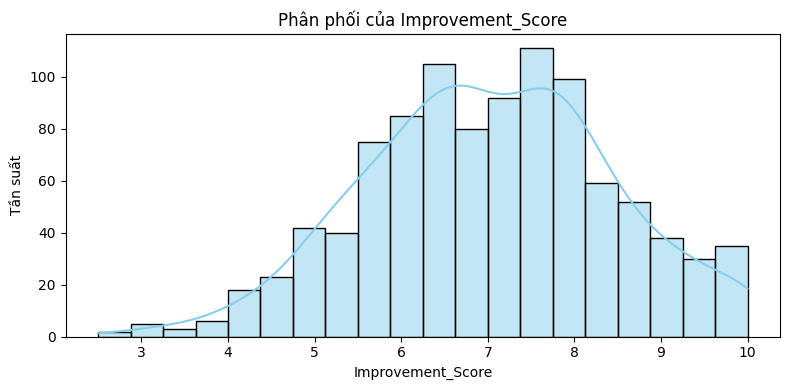

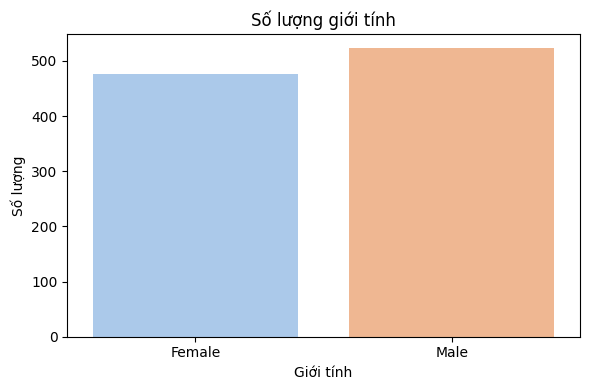

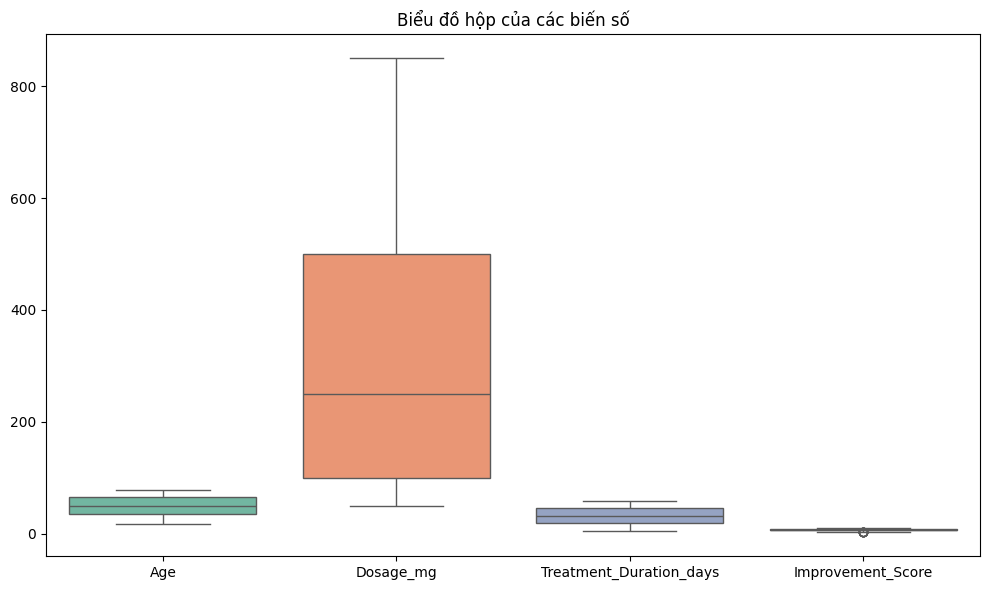

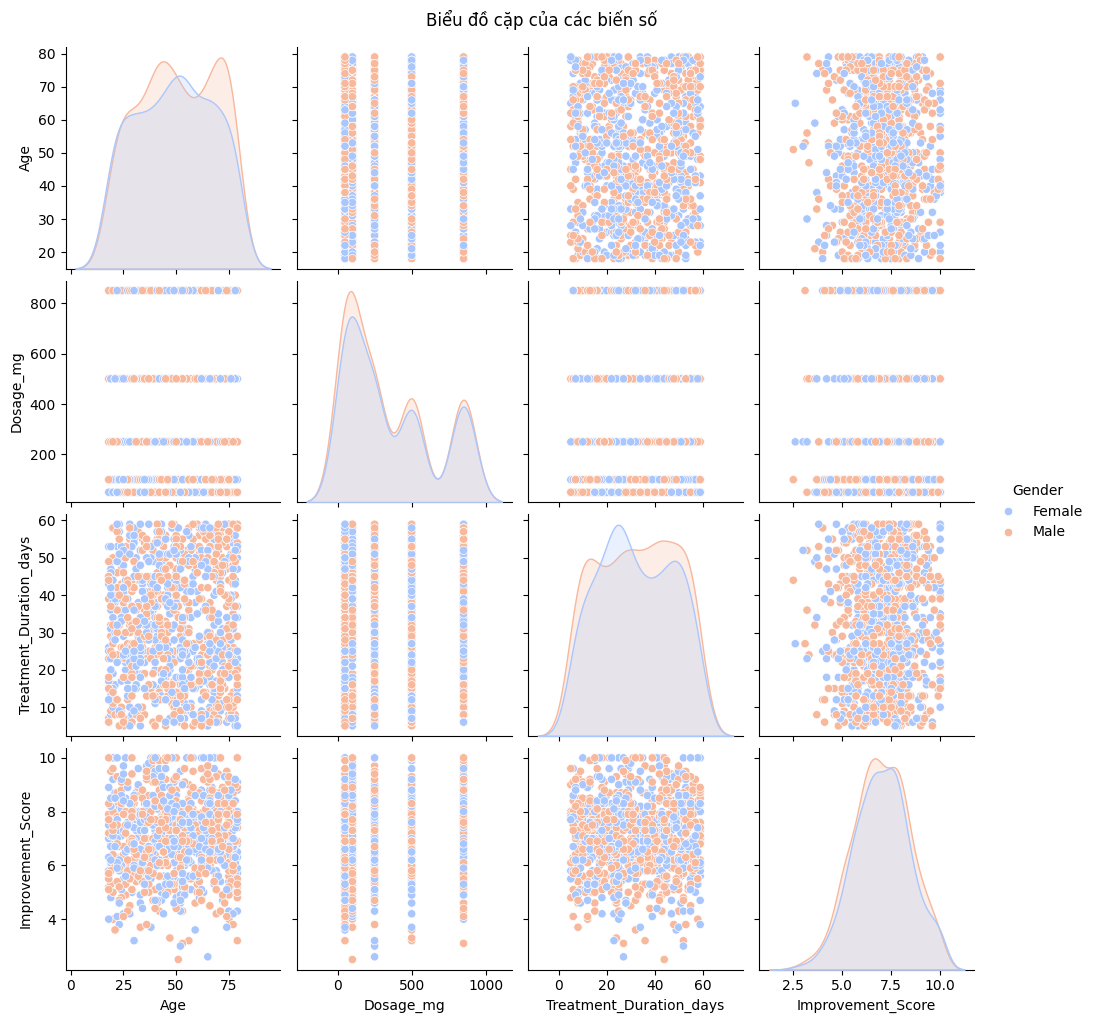

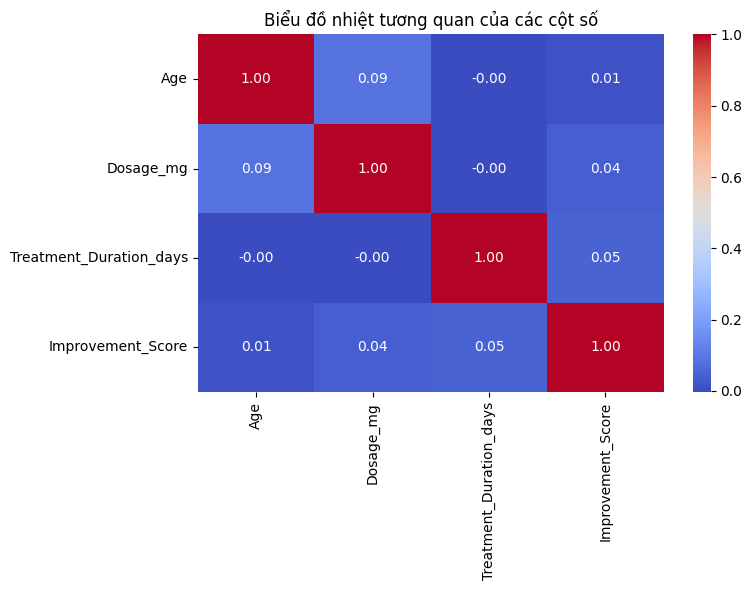

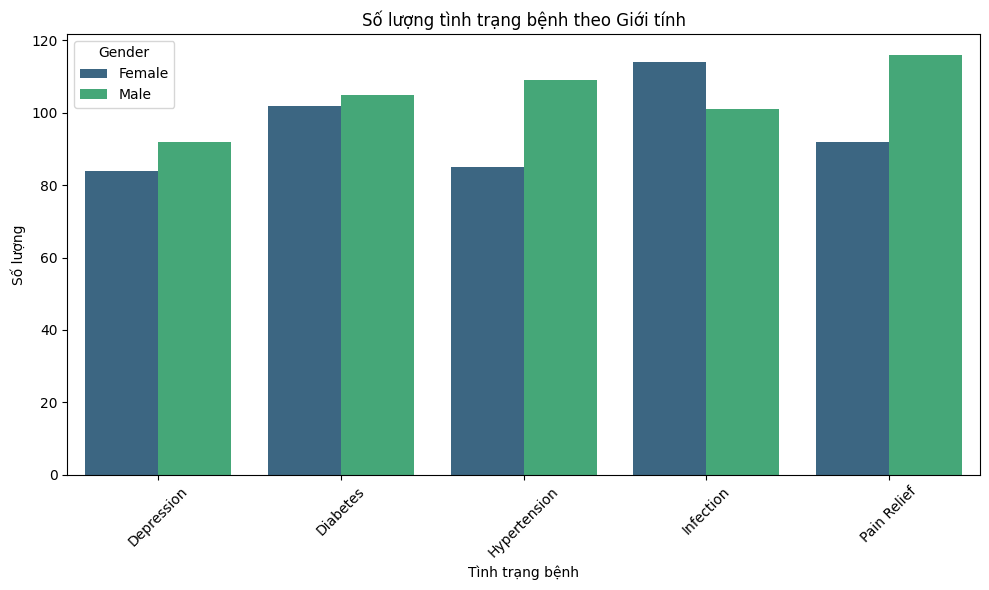

In [103]:
# Biểu đồ phân phối của các biến số
numeric_cols = ['Age', 'Dosage_mg', 'Treatment_Duration_days', 'Improvement_Score']
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df2[col], kde=True, color='skyblue')
    plt.title(f'Phân phối của {col}')
    plt.xlabel(col)
    plt.ylabel('Tần suất')
    plt.tight_layout()
    plt.show()

# Biểu đồ đếm cho dữ liệu phân loại như Giới tính
plt.figure(figsize=(6, 4))
sns.countplot(x='Gender', data=df2, hue='Gender', palette='pastel', legend=False)
plt.title('Số lượng giới tính')
plt.xlabel('Giới tính')
plt.ylabel('Số lượng')
plt.tight_layout()
plt.show()

# Biểu đồ hộp cho các biến số để đánh giá các giá trị ngoại lai
plt.figure(figsize=(10, 6))
sns.boxplot(data=df2[numeric_cols], palette='Set2')
plt.title('Biểu đồ hộp của các biến số')
plt.tight_layout()
plt.show()

# Biểu đồ cặp để hình dung mối quan hệ giữa các biến số và màu sắc theo Giới tính
sns.pairplot(df2, vars=numeric_cols, hue='Gender', palette='coolwarm')
plt.suptitle('Biểu đồ cặp của các biến số', y=1.02)
plt.show()

# Biểu đồ nhiệt cho mối tương quan giữa các biến số.
if len(numeric_cols) >= 4:
    numeric_df = df2[numeric_cols]
    corr = numeric_df.corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Biểu đồ nhiệt tương quan của các cột số')
    plt.tight_layout()
    plt.show()

# Biểu đồ cột nhóm: Số lượng tình trạng bệnh theo Giới tính
plt.figure(figsize=(10, 6))
sns.countplot(x='Condition', hue='Gender', data=df2, palette='viridis')
plt.title('Số lượng tình trạng bệnh theo Giới tính')
plt.xlabel('Tình trạng bệnh')
plt.ylabel('Số lượng')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Mô hình dự đoán

In [104]:

# 1. Tạo biến mục tiêu (Target)
median_score = df2['Improvement_Score'].median()
df2['Good_Improvement'] = (df2['Improvement_Score'] >= median_score).astype(int)

# 2. Chuẩn bị dữ liệu ĐẦU VÀO (X) - CHƯA CHUẨN HÓA
numerical_features = ['Age', 'Dosage_mg', 'Treatment_Duration_days']

# Mã hóa One-Hot cho các cột phân loại
df2_encoded = pd.get_dummies(df2[['Gender', 'Condition', 'Drug_Name']], drop_first=True)

# Kết hợp lại (Lúc này dữ liệu số vẫn là số gốc, chưa scale)
X = pd.concat([df2[numerical_features], df2_encoded], axis=1)

# 3. Chuẩn bị dữ liệu ĐẦU RA (y)
y_reg = df2['Improvement_Score']   # Cho bài toán hồi quy
y_clf = df2['Good_Improvement']    # Cho bài toán phân loại

# 4. CHIA TẬP DỮ LIỆU (QUAN TRỌNG: Chia trước khi chuẩn hóa)
# Chia cho bài toán Hồi quy
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)

# Chia cho bài toán Phân loại
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X, y_clf, test_size=0.2, random_state=42)

# 5. CHUẨN HÓA DỮ LIỆU (SCALING)
# Khởi tạo MinMaxScaler
scaler = MinMaxScaler()

# --- Áp dụng cho tập Phân loại (Classification) ---
X_train_clf[numerical_features] = scaler.fit_transform(X_train_clf[numerical_features])
X_test_clf[numerical_features] = scaler.transform(X_test_clf[numerical_features])

# --- Áp dụng cho tập Hồi quy (Regression) ---
# Cần tạo scaler riêng hoặc fit lại để đảm bảo tính khách quan (dù data giống nhau nhưng tách biệt quy trình là tốt nhất)
scaler_reg = MinMaxScaler()
X_train_reg[numerical_features] = scaler_reg.fit_transform(X_train_reg[numerical_features])
X_test_reg[numerical_features] = scaler_reg.transform(X_test_reg[numerical_features])

# Kiểm tra kết quả
print("Dữ liệu sau khi chia và chuẩn hóa:")
print("Kích thước tập Train:", X_train_clf.shape)
print("Kích thước tập Test:", X_test_clf.shape)
print("\n5 dòng đầu của tập Train:")
print(X_train_clf[numerical_features].head())

Dữ liệu sau khi chia và chuẩn hóa:
Kích thước tập Train: (800, 22)
Kích thước tập Test: (200, 22)

5 dòng đầu của tập Train:
          Age  Dosage_mg  Treatment_Duration_days
29   0.327869     0.0625                 0.555556
535  0.213115     0.5625                 0.777778
695  0.819672     1.0000                 0.759259
557  0.672131     1.0000                 0.611111
836  0.737705     0.0000                 0.222222


In [105]:
# 1. Hồi quy tuyến tính
lin_reg = LinearRegression()
lin_reg.fit(X_train_reg, y_train_reg)
y_pred_reg = lin_reg.predict(X_test_reg)

# Đánh giá hiệu suất hồi quy bằng cách sử dụng điểm R2
r2 = r2_score(y_test_reg, y_pred_reg)
print('Điểm R2 của hồi quy tuyến tính:', r2)

Điểm R2 của hồi quy tuyến tính: -0.04151119504132872


Độ chính xác của Hồi quy Logistic: 0.52
Báo cáo phân loại của Hồi quy Logistic:
               precision    recall  f1-score   support

           0       0.46      0.50      0.48        88
           1       0.58      0.54      0.56       112

    accuracy                           0.52       200
   macro avg       0.52      0.52      0.52       200
weighted avg       0.52      0.52      0.52       200

Độ chính xác trung bình CV của Logistic Regression: 0.501 (+/- 0.02672077843177478)
Điểm CV từng lần chạy (Logistic Regression):
  Lần 1: 0.54
  Lần 2: 0.49
  Lần 3: 0.46
  Lần 4: 0.49
  Lần 5: 0.53


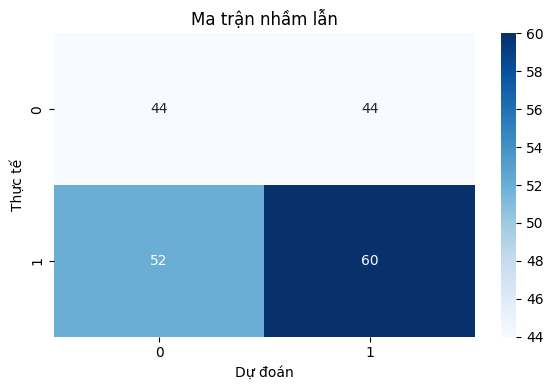

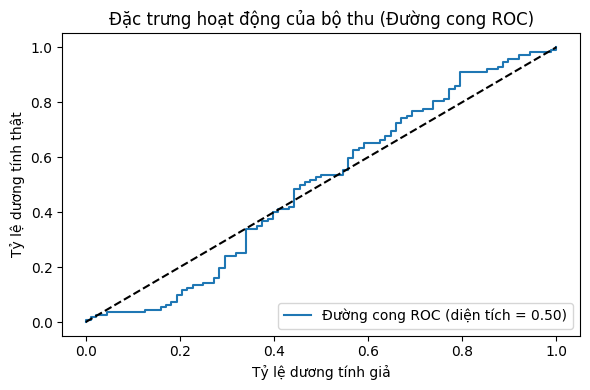

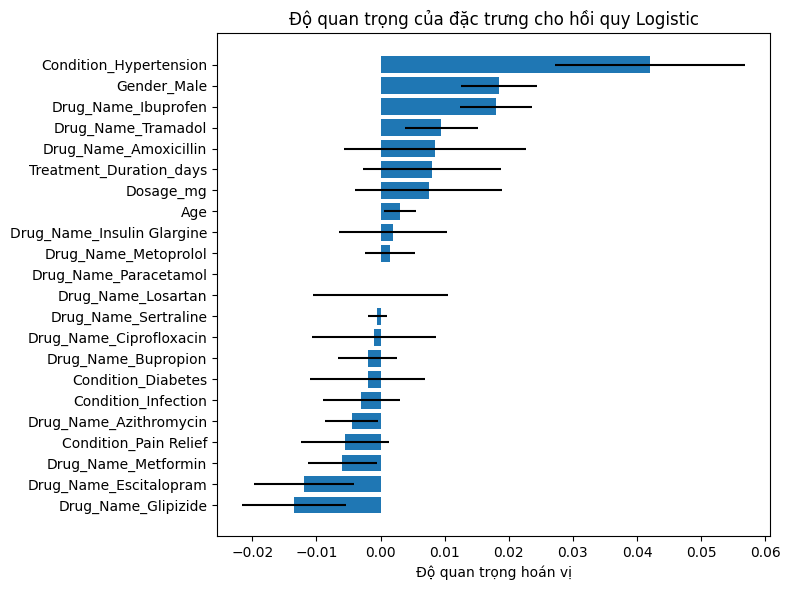

In [106]:
# 2. Hồi quy Logistic để phân loại cải thiện tốt
start_time_log_reg = time.time()
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_clf, y_train_clf)
training_time_log_reg = time.time() - start_time_log_reg

y_pred_clf = log_reg.predict(X_test_clf)

# Đánh giá hiệu suất phân loại
acc_log_reg = accuracy_score(y_test_clf, y_pred_clf)
report_log_reg = classification_report(y_test_clf, y_pred_clf, output_dict=True)
f1_log_reg = report_log_reg['1']['f1-score']

print('Độ chính xác của Hồi quy Logistic:', acc_log_reg)
print('Báo cáo phân loại của Hồi quy Logistic:\n', classification_report(y_test_clf, y_pred_clf))

# Xác thực chéo K-Fold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(log_reg, X, y_clf, cv=kfold, scoring='accuracy')
print(f'Độ chính xác trung bình CV của Logistic Regression: {cv_scores.mean()} (+/- {cv_scores.std()})')
print('Điểm CV từng lần chạy (Logistic Regression):')
for i, score in enumerate(cv_scores):
    print(f'  Lần {i+1}: {score:.2f}')

# Trực quan hóa ma trận nhầm lẫn
cm = confusion_matrix(y_test_clf, y_pred_clf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Ma trận nhầm lẫn')
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.tight_layout()
plt.show()

# Đường cong ROC và tính toán AUC
y_prob_log_reg = log_reg.predict_proba(X_test_clf)[:, 1]
fpr_log_reg, tpr_log_reg, thresholds_log_reg = roc_curve(y_test_clf, y_prob_log_reg)
roc_auc_log_reg = auc(fpr_log_reg, tpr_log_reg)

plt.figure(figsize=(6, 4))
plt.plot(fpr_log_reg, tpr_log_reg, label='Đường cong ROC (diện tích = %0.2f)' % roc_auc_log_reg)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tỷ lệ dương tính giả')
plt.ylabel('Tỷ lệ dương tính thật')
plt.title('Đặc trưng hoạt động của bộ thu (Đường cong ROC)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# Độ quan trọng hoán vị cho mô hình hồi quy logistic
result = permutation_importance(log_reg, X_test_clf, y_test_clf, n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(8, 6))
plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx], xerr=result.importances_std[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), X_test_clf.columns[sorted_idx])
plt.xlabel('Độ quan trọng hoán vị')
plt.title('Độ quan trọng của đặc trưng cho hồi quy Logistic')
plt.tight_layout()
plt.show()

Độ chính xác của Naive Bayes: 0.495
Báo cáo phân loại của Naive Bayes:
               precision    recall  f1-score   support

           0       0.43      0.43      0.43        88
           1       0.55      0.54      0.55       112

    accuracy                           0.49       200
   macro avg       0.49      0.49      0.49       200
weighted avg       0.50      0.49      0.50       200

Độ chính xác trung bình CV của Naive Bayes: 0.476 (+/- 0.0351283361405006)
Điểm CV từng lần chạy (Naive Bayes):
  Lần 1: 0.47
  Lần 2: 0.43
  Lần 3: 0.45
  Lần 4: 0.53
  Lần 5: 0.50

Thời gian huấn luyện GB: 1473.63 giây
Tham số tốt nhất: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


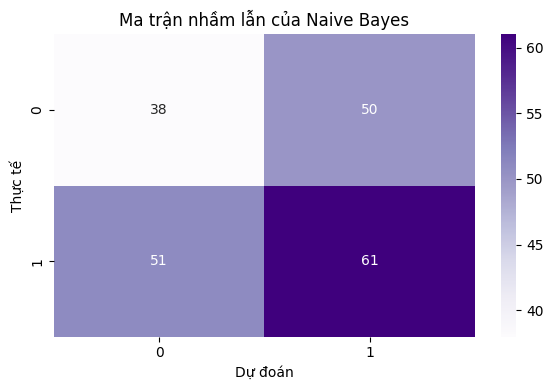

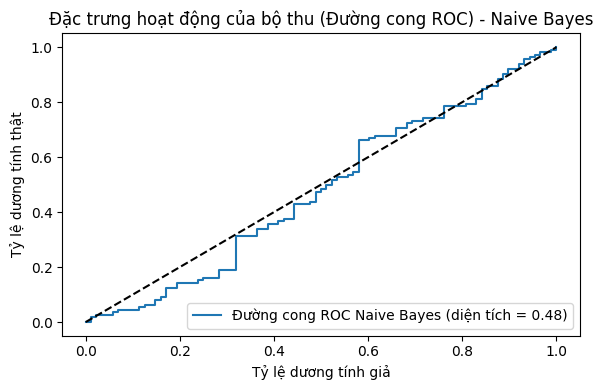

In [107]:
# 3. Naive Bayes để phân loại cải thiện tốt

start_time_mnb = time.time()
mnb_clf = MultinomialNB()
mnb_clf.fit(X_train_clf, y_train_clf)
training_time_mnb = time.time() - start_time_mnb

y_pred_mnb_clf = mnb_clf.predict(X_test_clf)

# Đánh giá hiệu suất phân loại Naive Bayes
acc_mnb = accuracy_score(y_test_clf, y_pred_mnb_clf)
report_mnb = classification_report(y_test_clf, y_pred_mnb_clf, output_dict=True)
f1_mnb = report_mnb['1']['f1-score']

print('Độ chính xác của Naive Bayes:', acc_mnb)
print('Báo cáo phân loại của Naive Bayes:\n', classification_report(y_test_clf, y_pred_mnb_clf))

# Xác thực chéo K-Fold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # Định nghĩa lại kfold nếu cần thiết
cv_scores_mnb = cross_val_score(mnb_clf, X, y_clf, cv=kfold, scoring='accuracy')
print(f'Độ chính xác trung bình CV của Naive Bayes: {cv_scores_mnb.mean()} (+/- {cv_scores_mnb.std()})')
print('Điểm CV từng lần chạy (Naive Bayes):')
for i, score in enumerate(cv_scores_mnb):
    print(f'  Lần {i+1}: {score:.2f}')

# Thời gian chạy của mô hình
training_time_gb = time.time() - start_time_gb
print(f"\nThời gian huấn luyện GB: {training_time_gb:.2f} giây")
print(f"Tham số tốt nhất: {grid_search_gb.best_params_}")

# Trực quan hóa ma trận nhầm lẫn cho Naive Bayes
cm_mnb = confusion_matrix(y_test_clf, y_pred_mnb_clf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_mnb, annot=True, fmt='d', cmap='Purples')
plt.title('Ma trận nhầm lẫn của Naive Bayes')
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.tight_layout()
plt.show()

# Đường cong ROC và tính toán AUC cho Naive Bayes
y_prob_mnb = mnb_clf.predict_proba(X_test_clf)[:, 1]
fpr_mnb, tpr_mnb, thresholds_mnb = roc_curve(y_test_clf, y_prob_mnb)
roc_auc_mnb = auc(fpr_mnb, tpr_mnb)

plt.figure(figsize=(6, 4))
plt.plot(fpr_mnb, tpr_mnb, label='Đường cong ROC Naive Bayes (diện tích = %0.2f)' % roc_auc_mnb)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tỷ lệ dương tính giả')
plt.ylabel('Tỷ lệ dương tính thật')
plt.title('Đặc trưng hoạt động của bộ thu (Đường cong ROC) - Naive Bayes')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

--- Bắt đầu tối ưu hóa Random Forest với Grid Search ---
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Thời gian huấn luyện: 24.97 giây
Tham số tốt nhất: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Độ chính xác của Random Forest (Best Model): 0.55
Báo cáo phân loại của Random Forest:
               precision    recall  f1-score   support

           0       0.49      0.55      0.52        88
           1       0.61      0.55      0.58       112

    accuracy                           0.55       200
   macro avg       0.55      0.55      0.55       200
weighted avg       0.56      0.55      0.55       200

Độ chính xác trung bình CV của Random Forest: 0.5170000000000001 (+/- 0.03586084215408223)
Điểm CV từng lần chạy (Random Forest):
  Lần 1: 0.56
  Lần 2: 0.46
  Lần 3: 0.50
  Lần 4: 0.52
  Lần 5: 0.56


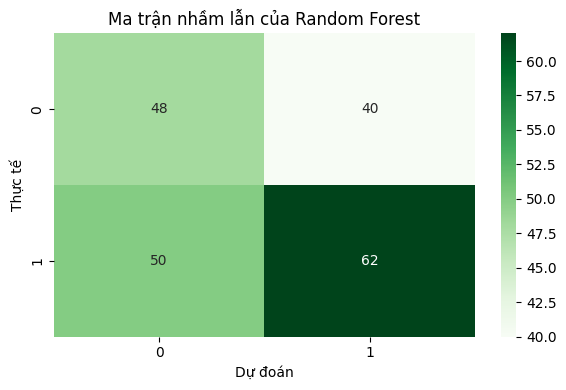

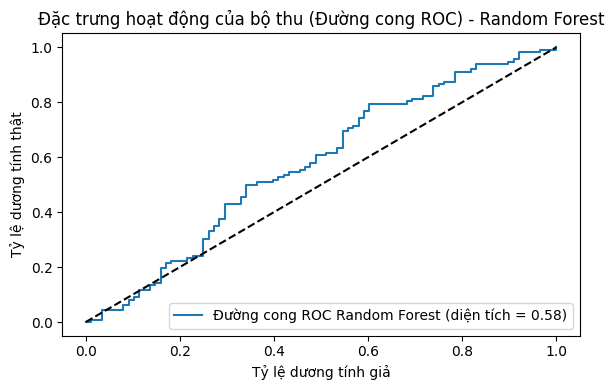

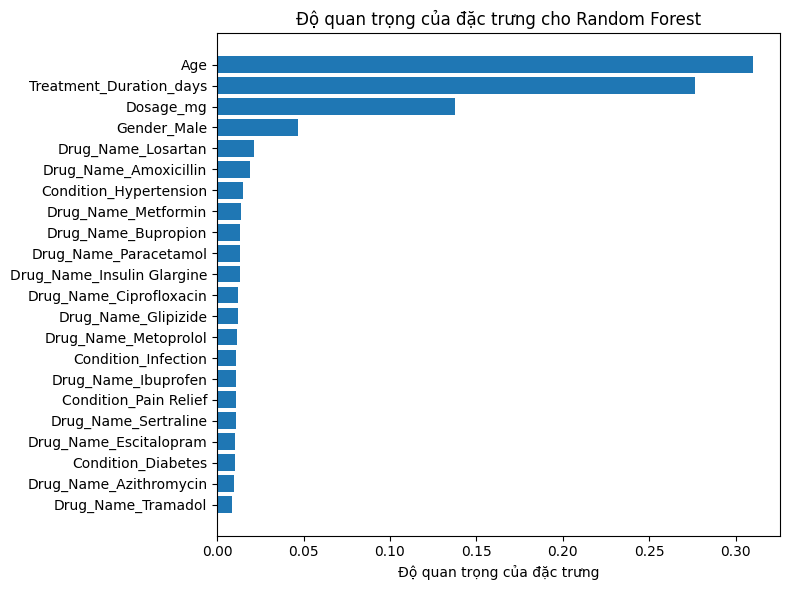

In [108]:
# 4. Random Forest để phân loại cải thiện tốt (kết hợp Grid Search)
print("--- Bắt đầu tối ưu hóa Random Forest với Grid Search ---")
start_time_rf = time.time()

# Định nghĩa không gian tham số cần tìm kiếm
param_grid = {
    'n_estimators': [100, 200],       # Số lượng cây
    'max_depth': [None, 10, 20],      # Độ sâu tối đa
    'min_samples_split': [2, 5],      # Số mẫu tối thiểu để tách nút
    'min_samples_leaf': [1, 2]        # Số mẫu tối thiểu tại lá
}

# Thiết lập Grid Search
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,                # Kiểm định chéo 5 lần
    scoring='accuracy',  # Ưu tiên độ chính xác
    n_jobs=-1,           # Chạy đa luồng
    verbose=1
)

# Huấn luyện (Fit) Grid Search thay vì model thường
grid_search.fit(X_train_clf, y_train_clf)

# Gán model tốt nhất vào biến rf_clf để code phía sau chạy bình thường
rf_clf = grid_search.best_estimator_

training_time_rf = time.time() - start_time_rf

print(f"Thời gian huấn luyện: {training_time_rf:.2f} giây")
print(f"Tham số tốt nhất: {grid_search.best_params_}")


y_pred_rf_clf = rf_clf.predict(X_test_clf)

# Đánh giá hiệu suất phân loại Random Forest
acc_rf = accuracy_score(y_test_clf, y_pred_rf_clf)
report_rf = classification_report(y_test_clf, y_pred_rf_clf, output_dict=True)

# Kiểm tra an toàn để tránh lỗi nếu lớp 1 không được dự đoán
if '1' in report_rf:
    f1_rf = report_rf['1']['f1-score']
else:
    f1_rf = 0

print('Độ chính xác của Random Forest (Best Model):', acc_rf)
print('Báo cáo phân loại của Random Forest:\n', classification_report(y_test_clf, y_pred_rf_clf))

# Xác thực chéo K-Fold
# Lưu ý: Biến X và y_clf phải là dữ liệu gốc (chưa split)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_rf = cross_val_score(rf_clf, X, y_clf, cv=kfold, scoring='accuracy')

print(f'Độ chính xác trung bình CV của Random Forest: {cv_scores_rf.mean()} (+/- {cv_scores_rf.std()})')
print('Điểm CV từng lần chạy (Random Forest):')
for i, score in enumerate(cv_scores_rf):
    print(f'  Lần {i+1}: {score:.2f}')

# Trực quan hóa ma trận nhầm lẫn cho Random Forest
cm_rf = confusion_matrix(y_test_clf, y_pred_rf_clf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens')
plt.title('Ma trận nhầm lẫn của Random Forest')
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.tight_layout()
plt.show()

# Đường cong ROC và tính toán AUC cho Random Forest
y_prob_rf = rf_clf.predict_proba(X_test_clf)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test_clf, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(6, 4))
plt.plot(fpr_rf, tpr_rf, label='Đường cong ROC Random Forest (diện tích = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tỷ lệ dương tính giả')
plt.ylabel('Tỷ lệ dương tính thật')
plt.title('Đặc trưng hoạt động của bộ thu (Đường cong ROC) - Random Forest')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# Độ quan trọng đặc trưng cho mô hình Random Forest
feature_importances = rf_clf.feature_importances_
sorted_idx_rf = feature_importances.argsort()

plt.figure(figsize=(8, 6))
plt.barh(range(len(sorted_idx_rf)), feature_importances[sorted_idx_rf], align='center')
# Xử lý trường hợp X_test_clf là numpy array hoặc DataFrame
if hasattr(X_test_clf, 'columns'):
    plt.yticks(range(len(sorted_idx_rf)), X_test_clf.columns[sorted_idx_rf])
else:
    plt.yticks(range(len(sorted_idx_rf)), sorted_idx_rf)
plt.xlabel('Độ quan trọng của đặc trưng')
plt.title('Độ quan trọng của đặc trưng cho Random Forest')
plt.tight_layout()
plt.show()

--- Bắt đầu tối ưu hóa Gradient Boosting ---
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Độ chính xác của Gradient Boosting (Best Model): 0.6000
Báo cáo phân loại:
               precision    recall  f1-score   support

           0       0.54      0.60      0.57        88
           1       0.66      0.60      0.63       112

    accuracy                           0.60       200
   macro avg       0.60      0.60      0.60       200
weighted avg       0.61      0.60      0.60       200


Thời gian huấn luyện GB: 73.94 giây
Tham số tốt nhất: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Độ chính xác trung bình CV của GB: 0.5170 (+/- 0.0312)
Điểm CV từng lần chạy (GB):
  Lần 1: 0.55
  Lần 2: 0.47
  Lần 3: 0.49
  Lần 4: 0.52
  Lần 5: 0.55


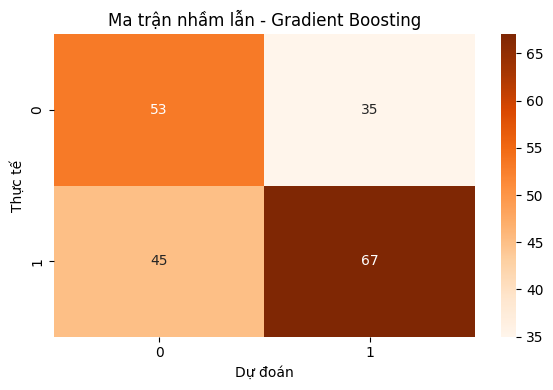

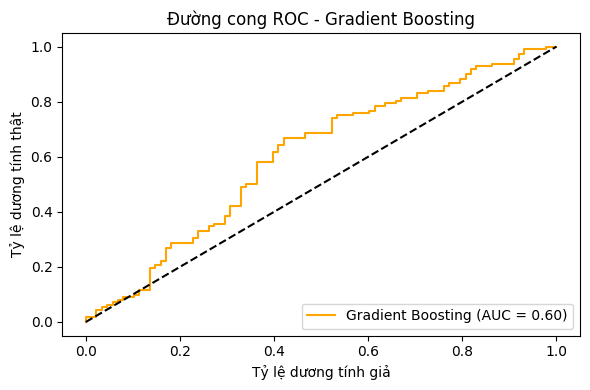

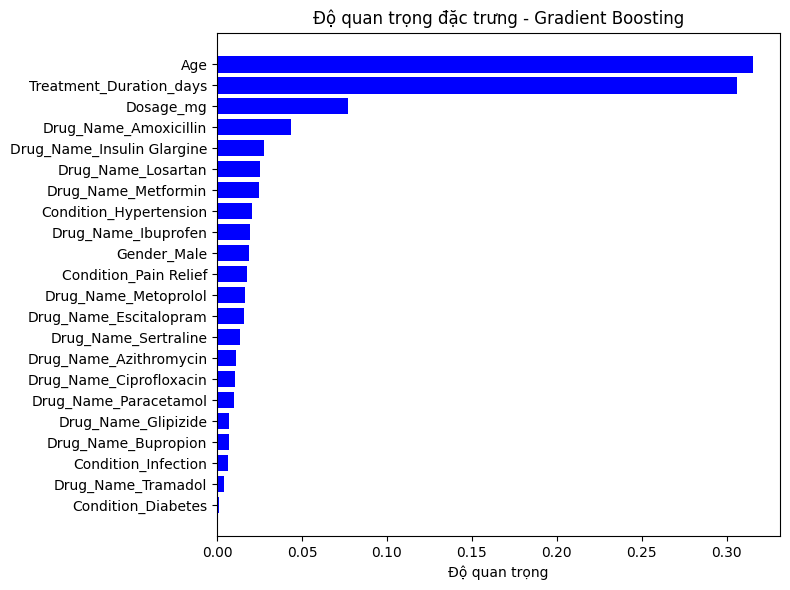

In [109]:
# 5. Gradient Boosting với Grid Search
print("--- Bắt đầu tối ưu hóa Gradient Boosting ---")
start_time_gb = time.time()

# Định nghĩa thâm số
param_grid_gb = {
    'n_estimators': [100, 200],       # Số lượng cây
    'learning_rate': [0.01, 0.1, 0.2], # Tốc độ học (quan trọng nhất của GB)
    'max_depth': [3, 5, 7],           # Độ sâu cây (sâu quá dễ bị overfitting)
    'subsample': [0.8, 1.0]           # Dùng bao nhiêu % dữ liệu để dựng mỗi cây
}

# Thiết lập Grid Search
gb_base = GradientBoostingClassifier(random_state=42)

grid_search_gb = GridSearchCV(
    estimator=gb_base,
    param_grid=param_grid_gb,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Huấn luyện
grid_search_gb.fit(X_train_clf, y_train_clf)

# Lấy ra mô hình tốt nhất
gb_clf = grid_search_gb.best_estimator_

# Dự đoán và đánh giá
y_pred_gb = gb_clf.predict(X_test_clf)

# Đánh giá hiệu suất
acc_gb = accuracy_score(y_test_clf, y_pred_gb)
report_gb = classification_report(y_test_clf, y_pred_gb, output_dict=True)

print(f'Độ chính xác của Gradient Boosting (Best Model): {acc_gb:.4f}')
print('Báo cáo phân loại:\n', classification_report(y_test_clf, y_pred_gb))

# Thời gian chạy của mô hình
training_time_gb = time.time() - start_time_gb
print(f"\nThời gian huấn luyện GB: {training_time_gb:.2f} giây")
print(f"Tham số tốt nhất: {grid_search_gb.best_params_}")

# Xác thực chéo K-Fold (trên toàn bộ dữ liệu X, y_clf)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_gb = cross_val_score(gb_clf, X, y_clf, cv=kfold, scoring='accuracy')

print(f'Độ chính xác trung bình CV của GB: {cv_scores_gb.mean():.4f} (+/- {cv_scores_gb.std():.4f})')
print('Điểm CV từng lần chạy (GB):')
for i, score in enumerate(cv_scores_gb):
    print(f'  Lần {i+1}: {score:.2f}')



# Ma trận nhầm lẫn
cm_gb = confusion_matrix(y_test_clf, y_pred_gb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Oranges') # Đổi màu Blues cho khác RF
plt.title('Ma trận nhầm lẫn - Gradient Boosting')
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.tight_layout()
plt.show()

# Đường cong ROC
y_prob_gb = gb_clf.predict_proba(X_test_clf)[:, 1]
fpr_gb, tpr_gb, thresholds_gb = roc_curve(y_test_clf, y_prob_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)

plt.figure(figsize=(6, 4))
plt.plot(fpr_gb, tpr_gb, label='Gradient Boosting (AUC = %0.2f)' % roc_auc_gb, color='orange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tỷ lệ dương tính giả')
plt.ylabel('Tỷ lệ dương tính thật')
plt.title('Đường cong ROC - Gradient Boosting')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# Độ quan trọng đặc trưng
feature_importances_gb = gb_clf.feature_importances_
sorted_idx_gb = feature_importances_gb.argsort()

plt.figure(figsize=(8, 6))
plt.barh(range(len(sorted_idx_gb)), feature_importances_gb[sorted_idx_gb], align='center', color='blue')
# Kiểm tra tên cột
if hasattr(X_test_clf, 'columns'):
    plt.yticks(range(len(sorted_idx_gb)), X_test_clf.columns[sorted_idx_gb])
else:
    plt.yticks(range(len(sorted_idx_gb)), sorted_idx_gb)
plt.xlabel('Độ quan trọng')
plt.title('Độ quan trọng đặc trưng - Gradient Boosting')
plt.tight_layout()
plt.show()

##So sánh các mô hình

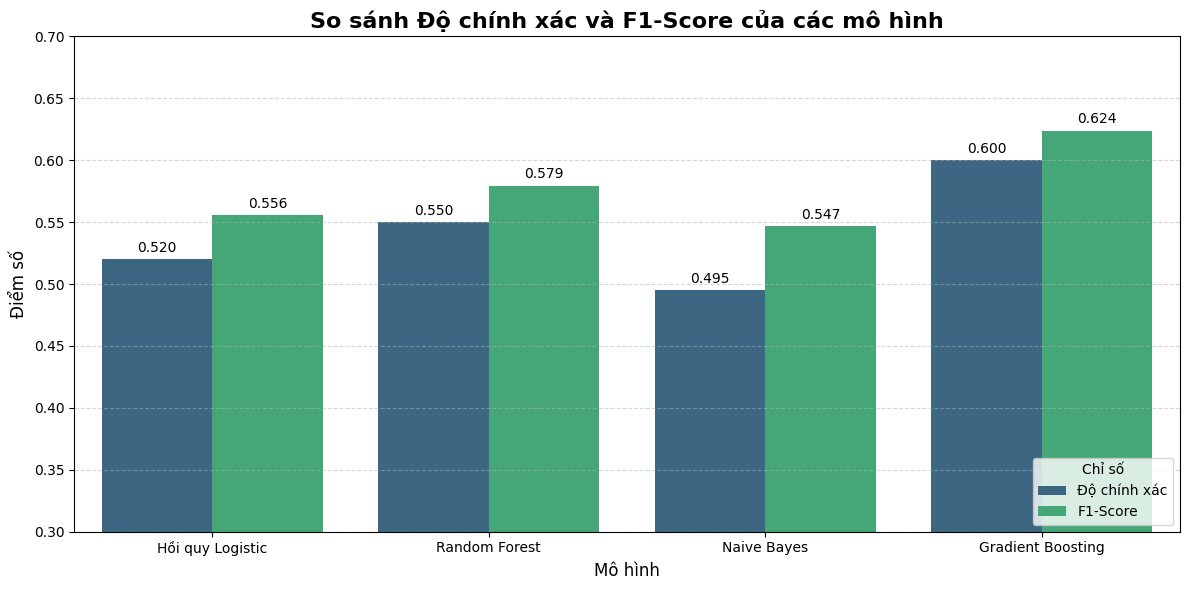

In [110]:
# Thu thập các chỉ số hiệu suất từ các mô hình
model_performance = {
    'Hồi quy Logistic': {
        'Độ chính xác (Test)': acc_log_reg,
        'F1-Score (Lớp Cải thiện tốt)': f1_log_reg,
        'AUC': roc_auc_log_reg
    },
    'Random Forest': {
        'Độ chính xác (Test)': acc_rf,
        'F1-Score (Lớp Cải thiện tốt)': f1_rf,
        'AUC': roc_auc_rf
    },
    'Naive Bayes': {
        'Độ chính xác (Test)': acc_mnb,
        'F1-Score (Lớp Cải thiện tốt)': f1_mnb,
        'AUC': roc_auc_mnb
    },
    'Gradient Boosting': {
        'Độ chính xác (Test)': acc_gb,
        'F1-Score (Lớp Cải thiện tốt)': f1_gb,
        'AUC': roc_auc_gb
    }
}

model_comparison_df = pd.DataFrame.from_dict(model_performance, orient='index')

# Thu thập thời gian huấn luyện
model_training_times = {
    'Hồi quy Logistic': training_time_log_reg,
    'Random Forest': training_time_rf,
    'Naive Bayes': training_time_mnb,
    'Gradient Boosting': training_time_gb
}

model_speed_df = pd.DataFrame.from_dict(model_training_times, orient='index', columns=['Thời gian huấn luyện (s)'])

df_plot = model_comparison_df.reset_index()
df_plot = df_plot[['index', 'Độ chính xác (Test)', 'F1-Score (Lớp Cải thiện tốt)']] # 'index' now holds the model names
df_plot.columns = ['Mô hình', 'Độ chính xác', 'F1-Score']

plt.figure(figsize=(12, 6))
df_melted = df_plot.melt(id_vars='Mô hình', var_name='Metric', value_name='Score')
ax = sns.barplot(x='Mô hình', y='Score', hue='Metric', data=df_melted, palette='viridis')
plt.ylim(0.3, 0.7)
plt.title('So sánh Độ chính xác và F1-Score của các mô hình', fontsize=16, fontweight='bold')
plt.ylabel('Điểm số', fontsize=12)
plt.xlabel('Mô hình', fontsize=12)
plt.legend(loc='lower right', title='Chỉ số')
plt.grid(axis='y', linestyle='--', alpha=0.5)

for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3, fontsize=10)

plt.tight_layout()
plt.show()

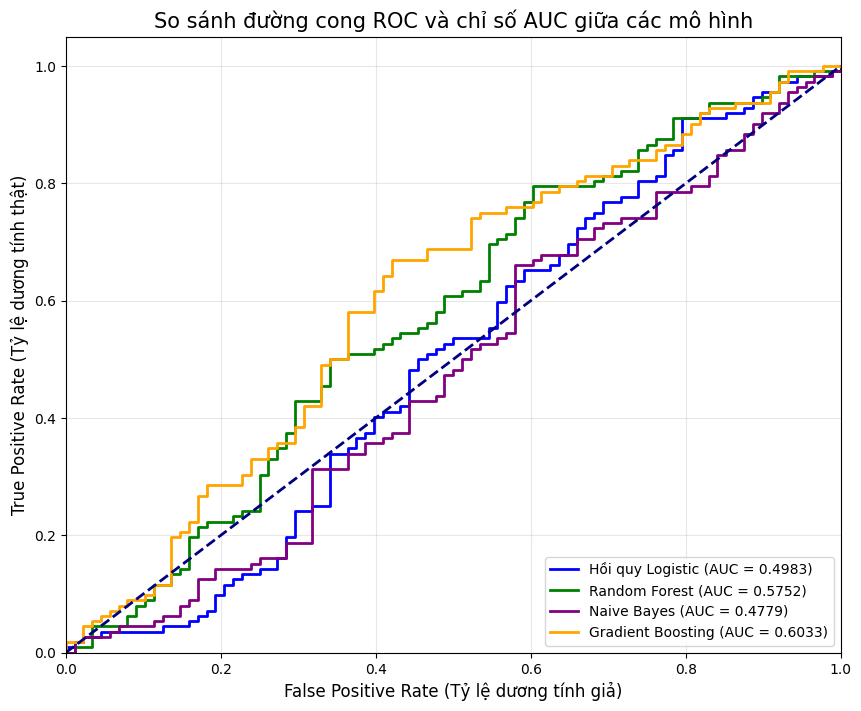

In [111]:
models_list = [log_reg, rf_clf, mnb_clf, gb_clf]
names_list = ['Hồi quy Logistic', 'Random Forest', 'Naive Bayes', 'Gradient Boosting']

colors = ['blue', 'green', 'purple', 'orange']

plt.figure(figsize=(10, 8))
for i, (model, name) in enumerate(zip(models_list, names_list)):
    # y_test và X_test cần được xác định rõ là y_test_clf và X_test_clf cho tác vụ phân loại.
    # Các biến này đã được khai báo ở các ô trước.
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test_clf)[:, 1]
    else:
        # Đối với các mô hình không có predict_proba (ví dụ: một số SVM), sử dụng decision_function
        y_prob = model.decision_function(X_test_clf)

    fpr, tpr, thresholds = roc_curve(y_test_clf, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.4f})', color=colors[i])

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Tỷ lệ dương tính giả)', fontsize=12)
plt.ylabel('True Positive Rate (Tỷ lệ dương tính thật)', fontsize=12)
plt.title('So sánh đường cong ROC và chỉ số AUC giữa các mô hình', fontsize=15)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

plt.show()

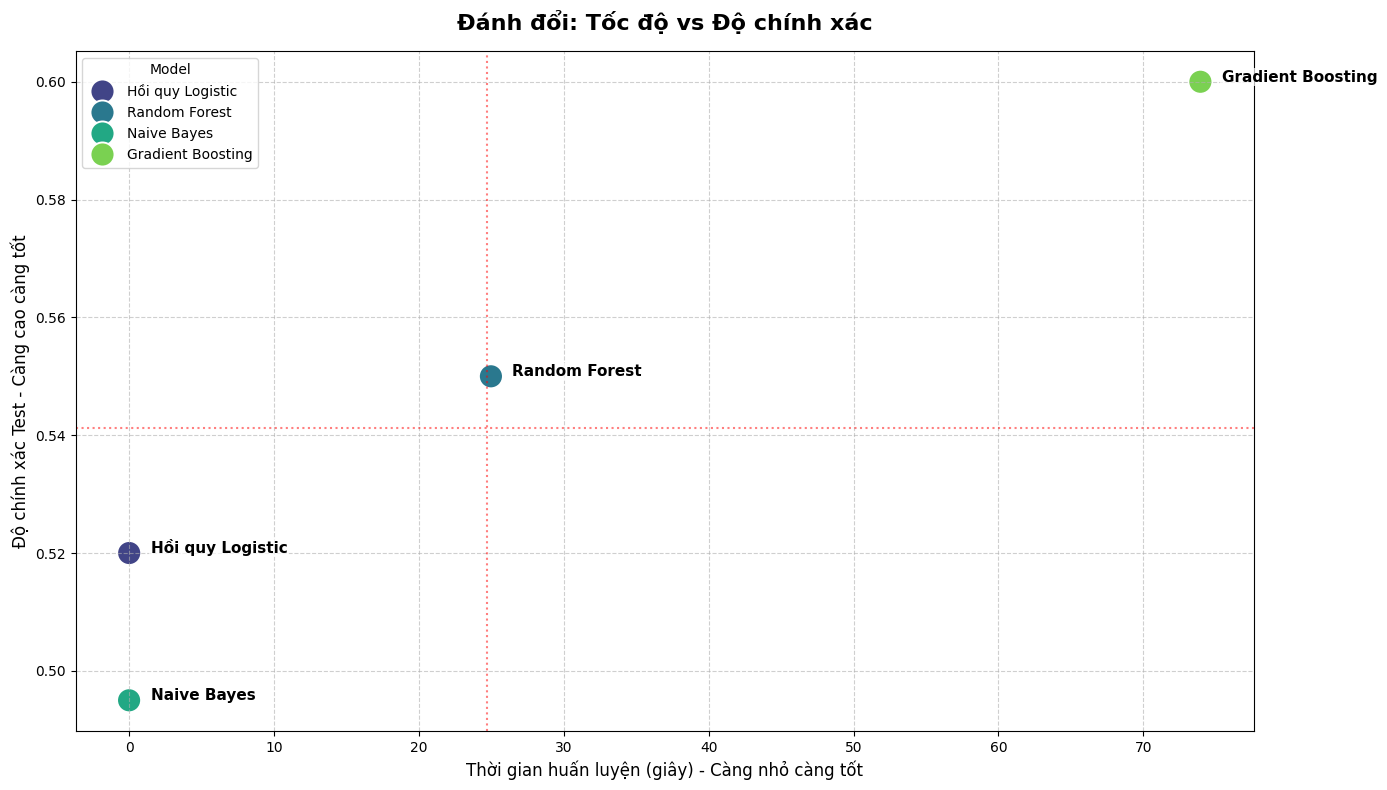

In [112]:
# Kết hợp các bảng so sánh hiệu suất và tốc độ
df_combined = pd.merge(model_comparison_df, model_speed_df, left_index=True, right_index=True)

# Chuẩn bị DataFrame cho biểu đồ
df_perf = df_combined.reset_index().rename(columns={
    'index': 'Model', # Sửa lỗi: đổi 'Mô hình' thành 'index'
    'Độ chính xác (Test)': 'Test Accuracy',
    'Thời gian huấn luyện (s)': 'Training Time (s)'
})

fig, axes = plt.subplots(1, 1, figsize=(14, 8), squeeze=False)

sns.scatterplot(data=df_perf, x='Training Time (s)', y='Test Accuracy',
                hue='Model', s=300, ax=axes[0, 0], palette='viridis')

for i in range(df_perf.shape[0]):
    x_val = df_perf['Training Time (s)'][i]
    y_val = df_perf['Test Accuracy'][i]
    # Điều chỉnh vị trí chữ để không bị chồng lên điểm
    x_offset = df_perf['Training Time (s)'].max() * 0.02

    axes[0, 0].text(x_val + x_offset, y_val,
                    df_perf['Model'][i], fontsize=11, fontweight='bold',
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))

axes[0, 0].set_title('Đánh đổi: Tốc độ vs Độ chính xác', fontsize=16, fontweight='bold', pad=15)
axes[0, 0].set_xlabel('Thời gian huấn luyện (giây) - Càng nhỏ càng tốt', fontsize=12)
axes[0, 0].set_ylabel('Độ chính xác Test - Càng cao càng tốt', fontsize=12)
axes[0, 0].grid(True, linestyle='--', alpha=0.6)

avg_time = df_perf['Training Time (s)'].mean()
avg_acc = df_perf['Test Accuracy'].mean()
axes[0, 0].axvline(avg_time, color='red', linestyle=':', alpha=0.5, label=f'Thời gian huấn luyện trung bình: {avg_time:.3f}s')
axes[0, 0].axhline(avg_acc, color='red', linestyle=':', alpha=0.5, label=f'Độ chính xác Test trung bình: {avg_acc:.3f}')

# Thêm legend cho các đường trung bình nếu muốn
# axes[0, 0].legend(title='Giá trị trung bình')

plt.tight_layout()
plt.show()

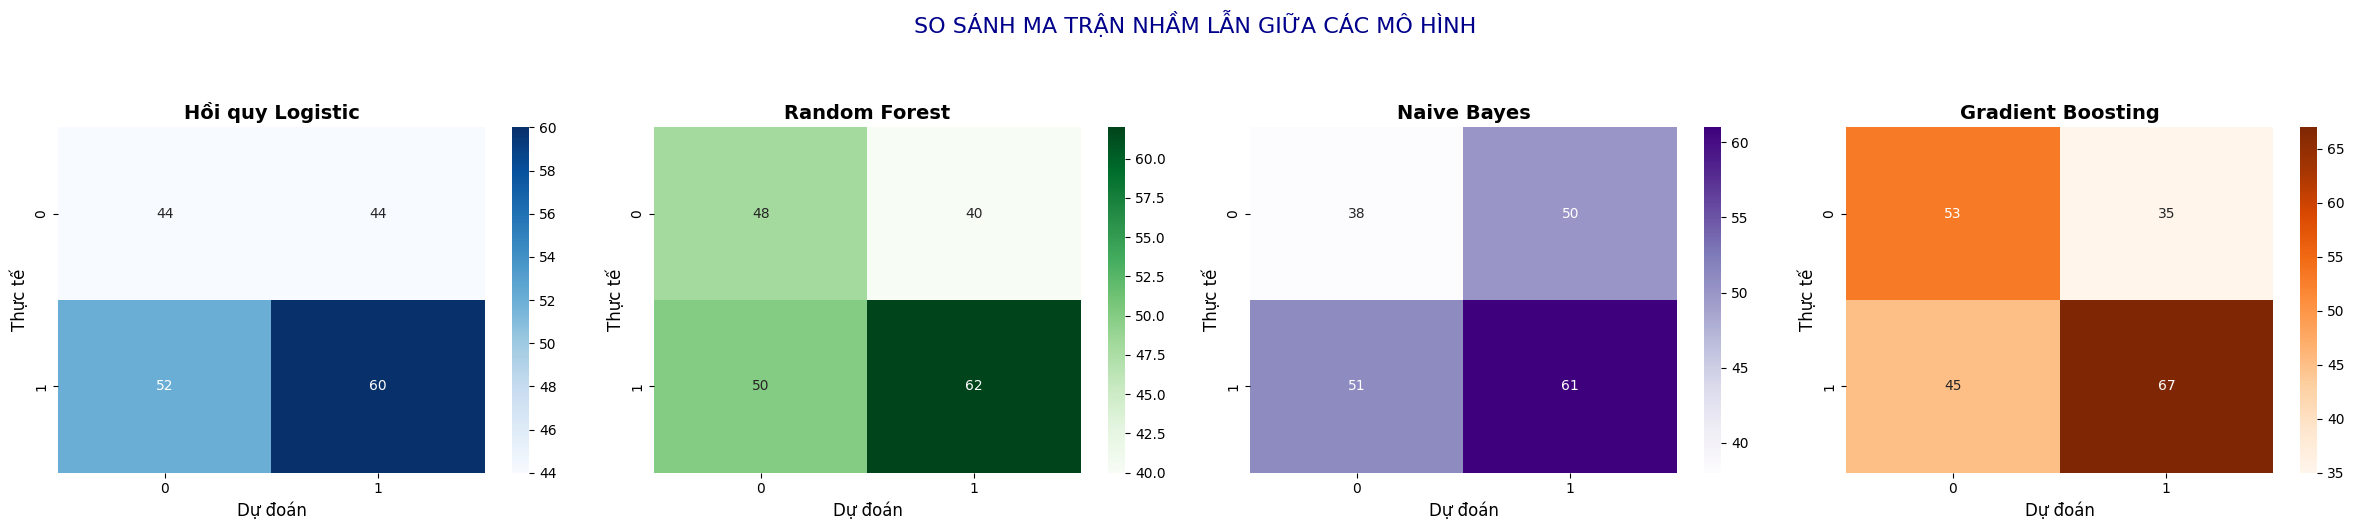

In [113]:

confusion_matrices = {
    'Hồi quy Logistic': cm,
    'Random Forest': cm_rf,
    'Naive Bayes': cm_mnb,
    'Gradient Boosting': cm_gb
}

class_labels = ['0', '1']

colormaps = {
    'Hồi quy Logistic': 'Blues',
    'Random Forest': 'Greens',
    'Naive Bayes': 'Purples',
    'Gradient Boosting': 'Oranges' # Thêm Gradient Boosting vào từ điển colormaps
}
fig, axes = plt.subplots(1, len(confusion_matrices), figsize=(len(confusion_matrices) * 6, 5)) # Điều chỉnh kích thước và số lượng subplot
axes = axes.flatten() if len(confusion_matrices) > 1 else [axes]

for i, (name, cm_matrix) in enumerate(confusion_matrices.items()):
    sns.heatmap(cm_matrix, annot=True, fmt='d', cmap=colormaps[name],
                xticklabels=class_labels,
                yticklabels=class_labels,
                ax=axes[i])
    axes[i].set_title(f'{name}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Dự đoán', fontsize=12)
    axes[i].set_ylabel('Thực tế', fontsize=12)

plt.suptitle('SO SÁNH MA TRẬN NHẦM LẪN GIỮA CÁC MÔ HÌNH', y=1.05, fontsize=16, color='darkblue')
plt.tight_layout(rect=[0, 0, 1, 0.98]) # Điều chỉnh rect để tiêu đề không bị chồng lấn
plt.show()

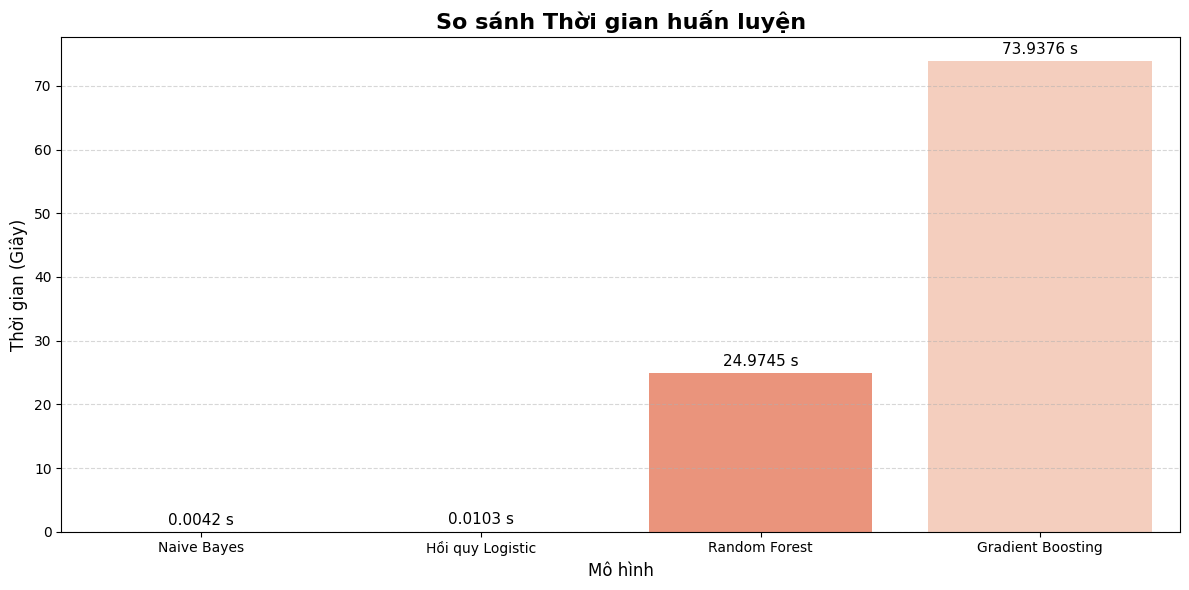

In [114]:
df_plot_time = model_speed_df.reset_index()
df_plot_time = df_plot_time.rename(columns={
    'index': 'Model',
    'Thời gian huấn luyện (s)': 'Time (s)'
})

df_time_sorted = df_plot_time.sort_values(by='Time (s)', ascending=True)

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x='Model',
    y='Time (s)',
    data=df_time_sorted,
    palette='Reds_r',
    hue='Model',
    legend=False
)

plt.title('So sánh Thời gian huấn luyện', fontsize=16, fontweight='bold')
plt.ylabel('Thời gian (Giây)', fontsize=12)
plt.xlabel('Mô hình', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

for container in ax.containers:
    ax.bar_label(container, fmt='%.4f s', padding=3, fontsize=11)

plt.tight_layout()
plt.show()

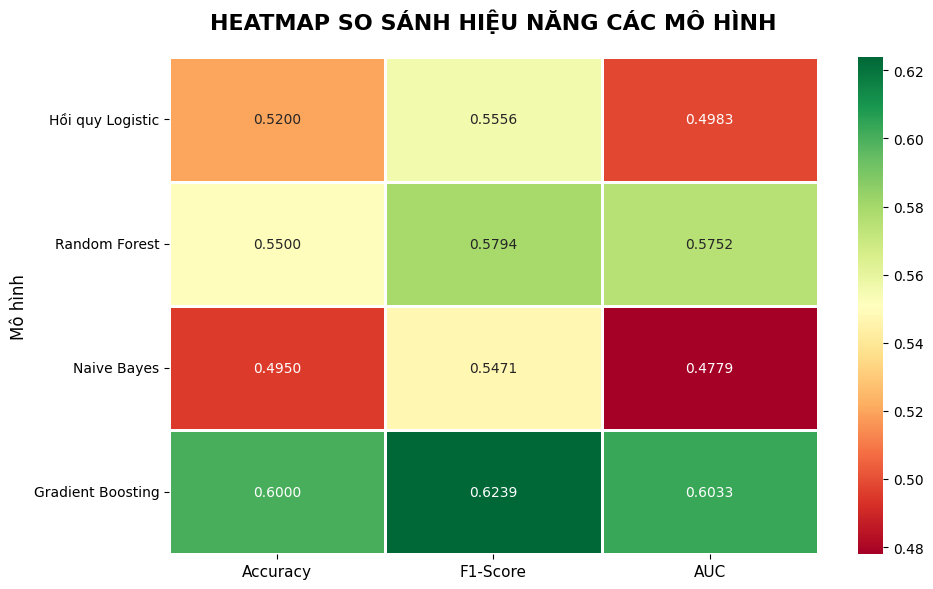

In [115]:
heatmap_data = model_comparison_df.copy()
# Chọn và đổi tên các cột để phù hợp với yêu cầu của biểu đồ nhiệt
heatmap_data = heatmap_data[['Độ chính xác (Test)', 'F1-Score (Lớp Cải thiện tốt)', 'AUC']]
heatmap_data.columns = ['Accuracy', 'F1-Score', 'AUC']

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt='.4f', cmap='RdYlGn', linewidths=1, linecolor='white')

plt.title('HEATMAP SO SÁNH HIỆU NĂNG CÁC MÔ HÌNH', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Mô hình', fontsize=12)
plt.yticks(rotation=0)
plt.xticks(fontsize=11)

plt.tight_layout()
plt.show()

In [116]:
best_model = gb_clf
best_model_name = "gradient_boosting_drug_improvement_classifier"
second_model_name = "random_forest_drug_improvement_classifier"

if not os.path.exists('saved_models'):
    os.makedirs('saved_models')

joblib.dump(best_model, os.path.join('saved_models', best_model_name + '.pkl'))
joblib.dump(rf_clf, os.path.join('saved_models', second_model_name + '.pkl'))

['saved_models/random_forest_drug_improvement_classifier.pkl']

In [117]:
raw_sample_data = {
    'Age': [45, 60, 30, 55, 70, 25],
    'Dosage_mg': [200, 500, 100, 750, 800, 150],
    'Treatment_Duration_days': [30, 45, 15, 50, 60, 10],
    'Gender': ['Male', 'Male', 'Female', 'Female', 'Male', 'Female'],
    'Condition': ['Hypertension', 'Diabetes', 'Infection', 'Pain Relief', 'Depression', 'Hypertension'],
    'Drug_Name': ['Metoprolol', 'Glipizide', 'Ciprofloxacin', 'Ibuprofen', 'Sertraline', 'Amlodipine']
}

raw_sample_df = pd.DataFrame(raw_sample_data)

numerical_sample_features = raw_sample_df[['Age', 'Dosage_mg', 'Treatment_Duration_days']]
categorical_sample_df_encoded = pd.get_dummies(raw_sample_df[['Gender', 'Condition', 'Drug_Name']], drop_first=True)
sample_processed_X = pd.concat([numerical_sample_features, categorical_sample_df_encoded], axis=1)
final_sample_df = sample_processed_X.reindex(columns=X_train_clf.columns, fill_value=0)

print("Dữ liệu mẫu đầu vào (đã xử lý để dự đoán):\n")
display(final_sample_df)

loaded_gb_model = joblib.load(os.path.join('saved_models', best_model_name + '.pkl'))
loaded_rf_model = joblib.load(os.path.join('saved_models', second_model_name + '.pkl'))

models_to_test = [
    (loaded_gb_model, "Gradient Boosting"),
    (loaded_rf_model, "Random Forest")
]

for model, model_display_name in models_to_test:
    predictions = model.predict(final_sample_df)
    prediction_probabilities = model.predict_proba(final_sample_df)[:, 1]

    results_df = raw_sample_df.copy()
    results_df[f'Dự đoán ({model_display_name})'] = predictions
    results_df[f'Xác suất Cải thiện tốt ({model_display_name})'] = prediction_probabilities.round(3)

    print(f"\n--- Kết quả Dự đoán từ mô hình: {model_display_name} ---")
    display(results_df)
    print(f"\nNhận xét: '0' = Không cải thiện tốt (<{median_score}), '1' = Cải thiện tốt (>={median_score})")

Dữ liệu mẫu đầu vào (đã xử lý để dự đoán):



,Age,Dosage_mg,Treatment_Duration_days,Gender_Male,Condition_Diabetes,Condition_Hypertension,Condition_Infection,Condition_Pain Relief,Drug_Name_Amoxicillin,Drug_Name_Azithromycin,...,Drug_Name_Escitalopram,Drug_Name_Glipizide,Drug_Name_Ibuprofen,Drug_Name_Insulin Glargine,Drug_Name_Losartan,Drug_Name_Metformin,Drug_Name_Metoprolol,Drug_Name_Paracetamol,Drug_Name_Sertraline,Drug_Name_Tramadol
0,45,200,30,True,False,True,False,False,0,0,...,0,False,False,0,0,0,True,0,False,0
1,60,500,45,True,True,False,False,False,0,0,...,0,True,False,0,0,0,False,0,False,0
2,30,100,15,False,False,False,True,False,0,0,...,0,False,False,0,0,0,False,0,False,0
3,55,750,50,False,False,False,False,True,0,0,...,0,False,True,0,0,0,False,0,False,0
4,70,800,60,True,False,False,False,False,0,0,...,0,False,False,0,0,0,False,0,True,0
5,25,150,10,False,False,True,False,False,0,0,...,0,False,False,0,0,0,False,0,False,0



--- Kết quả Dự đoán từ mô hình: Gradient Boosting ---


,Age,Dosage_mg,Treatment_Duration_days,Gender,Condition,Drug_Name,Dự đoán (Gradient Boosting),Xác suất Cải thiện tốt (Gradient Boosting)
0,45,200,30,Male,Hypertension,Metoprolol,1,0.538
1,60,500,45,Male,Diabetes,Glipizide,0,0.460
2,30,100,15,Female,Infection,Ciprofloxacin,1,0.545
3,55,750,50,Female,Pain Relief,Ibuprofen,1,0.751
4,70,800,60,Male,Depression,Sertraline,1,0.554
5,25,150,10,Female,Hypertension,Amlodipine,1,0.732



Nhận xét: '0' = Không cải thiện tốt (<7.0), '1' = Cải thiện tốt (>=7.0)

--- Kết quả Dự đoán từ mô hình: Random Forest ---


,Age,Dosage_mg,Treatment_Duration_days,Gender,Condition,Drug_Name,Dự đoán (Random Forest),Xác suất Cải thiện tốt (Random Forest)
0,45,200,30,Male,Hypertension,Metoprolol,1,0.560
1,60,500,45,Male,Diabetes,Glipizide,0,0.403
2,30,100,15,Female,Infection,Ciprofloxacin,0,0.417
3,55,750,50,Female,Pain Relief,Ibuprofen,1,0.593
4,70,800,60,Male,Depression,Sertraline,0,0.467
5,25,150,10,Female,Hypertension,Amlodipine,1,0.505



Nhận xét: '0' = Không cải thiện tốt (<7.0), '1' = Cải thiện tốt (>=7.0)
